Below is a test for 22bit data in with 18 bit twiddle factor.

In [73]:
import numpy as np
from matplotlib import pyplot as plt

Input vector is 32k $\times$ 1000 long (My laptop only has so much memory). The vector will be comprised of noise and a single tone.

SNR =  31.67490586532339
dBFS =  -31.826964502457965


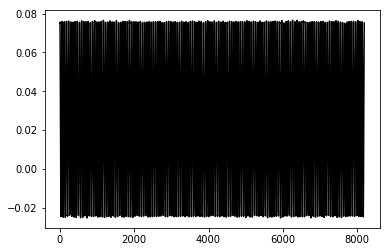

In [74]:
iters = 1e4
N = int(2**13)
noise = (((np.random.normal(size=N,scale = 0.3))+0.5).astype(np.float64)/800)
tone = ((np.cos(280*np.pi*np.arange(N)/N)+0.5).astype(np.float64)/20)
input_vector = (tone+noise)
plt.plot(input_vector,'k')
print("SNR = ", 20*np.log10(np.max(np.abs(tone[:2**12]))/np.max(np.abs(noise[:2**12]))))
print("dBFS = ", 20*np.log10(np.mean(input_vector[:2**12])/(1)))
#np.save("input_vector",input_vector-np.mean(input_vector))

The above test vector has an SNR of ~60dB and a non-comensurate tone. This will be used as the input vector to the FFT in the following tests.

In [75]:

from fixpoint import fixpoint, cfixpoint
from pfb_fixed import iterffft_natural_DIT as fixFFT
from pfb_fixed import make_fix_twiddle, bitrevfixarray, bit_rev
#input_vector = np.load("input_vector.npy",mmap_mode='r')

Once we have out input vector memory mapped, we convert it to cfixpoint type in 32k slices, square and sum the output and then load the next 32k points.

In [87]:
fixinput = cfixpoint(22,22) #22 bit fixpoint number that will use even-rounding
fixtwids = make_fix_twiddle(2**16,18,17) #18 bit twiddle factor that uses even rounding
fixtwids = bitrevfixarray(fixtwids,fixtwids.data.size)
shiftreg = [1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1]
output_vector = np.zeros(2**15,dtype=np.float64)
#for i in range(iters):
    #print(i)
    #slc = slice(int(i*2**16),int(i*2**16+2**16),1)
    #fixinput.from_complex(input_vector[slc])
    #out= np.abs(fixFFT(fixinput,fixtwids,shiftreg.copy(),22,22,18,staged=False).to_complex())[:2**15]
    #output_vector += out
#np.save("output_vector_18bit_twiddle",output_vector)
fixinput.from_complex(input_vector)
s= fixinput.data[:10]
a= np.zeros(10,dtype=np.complex128)
a[:]=s[:]

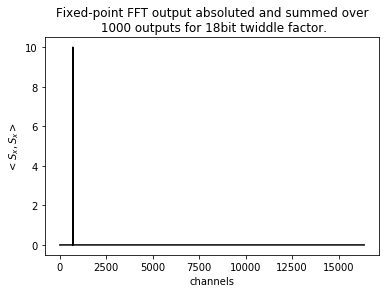

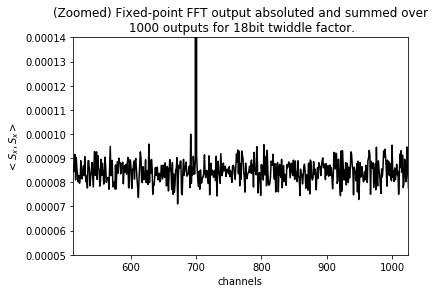

In [23]:
output_vector = np.load("output_vector_18bit_twiddle.npy",mmap_mode = 'r')
fig = plt.figure(1)
v = plt.plot(output_vector,'k')
plt.title("Fixed-point FFT output absoluted and summed over\n 1000 outputs for 18bit twiddle factor.")
plt.xlabel("channels")
plt.ylabel("$<S_{x},S_{x}>$")
plt.show()
s = plt.plot(output_vector,'k')
plt.title("(Zoomed) Fixed-point FFT output absoluted and summed over\n 1000 outputs for 18bit twiddle factor.")
plt.xlabel("channels")
plt.ylabel("$<S_{x},S_{x}>$")
plt.xlim((512,1024))
plt.ylim((0.00005,0.00014))
plt.show()

No apparent dips.
Now we try a 22 bit twiddle factor for comparison.

In [27]:
fixinput = cfixpoint(22,22) #22 bit fixpoint number that will use even-rounding
fixtwids = make_fix_twiddle(2**16,22,21) #22 bit twiddle factor that uses even rounding
fixtwids = bitrevfixarray(fixtwids,fixtwids.data.size)
shiftreg = [1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1]
output_vector = np.zeros(2**15,dtype=np.float64)
for i in range(iters):
    print(i)
    slc = slice(int(i*2**16),int(i*2**16+2**16),1)
    fixinput.from_complex(input_vector[slc])
    out= np.abs(fixFFT(fixinput,fixtwids,shiftreg.copy(),22,22,22,staged=False).to_complex())[:2**15]
    output_vector += out
np.save("output_vector_22bit_twiddle",output_vector)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


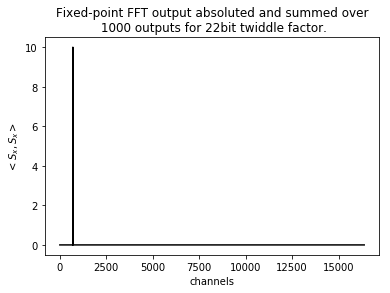

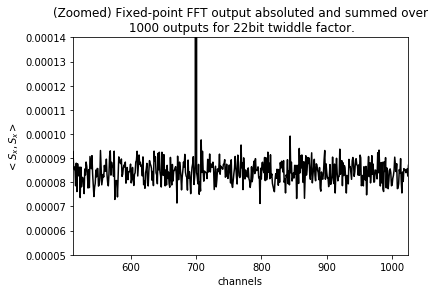

In [38]:
output_vector = np.load("output_vector_22bit_twiddle_uncorrnoise.npy",mmap_mode = 'r')
fig = plt.figure(1)
v = plt.plot(output_vector,'k')
plt.title("Fixed-point FFT output absoluted and summed over\n 1000 outputs for 22bit twiddle factor.")
plt.xlabel("channels")
plt.ylabel("$<S_{x},S_{x}>$")
plt.show()
s = plt.plot(output_vector,'k')
plt.title("(Zoomed) Fixed-point FFT output absoluted and summed over\n 1000 outputs for 22bit twiddle factor.")
plt.xlabel("channels")
plt.ylabel("$<S_{x},S_{x}>$")
plt.xlim((512,1024))
plt.ylim((0.00005,0.00014))
plt.show()

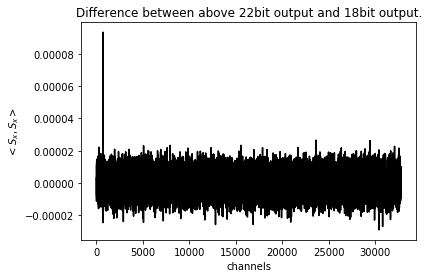

9.346008925881222e-05
9.999996900774477


In [40]:
output_vector1 = np.load("output_vector_22bit_twiddle_uncorrnoise.npy",mmap_mode = 'r')
output_vector2 = np.load("output_vector_18bit_twiddle_uncorrnoise.npy",mmap_mode = 'r')
fig = plt.figure(1)
v = plt.plot(output_vector1-output_vector2,'k')
plt.title("Difference between above 22bit output and 18bit output.")
plt.xlabel("channels")
plt.ylabel("$<S_{x},S_{x}>$")
plt.show()

As can be seen, the dips visable in the CASPER PFB implementation are not present in this simulator.

I'm uncertain about why the 22bit and 18bit twiddle factor cases differ slightly ($\approx < $ 0.00095 %) in amplitude overall, but, in part, it may be owed to the multiplication performed in the butterfly between the twiddle and the one point:

$W_{i}\times X_{n}$ where W is the twiddle factor and X is a point.

For the case when we are performing a multiplication between the 18bit twiddle and 22bit point, after multiplication we will remove (or right shift) off 17bits (brought in through multiplcation) before adding the 23bit result to the other point (22bit), thereby completing the butterfly.

The case for the 22bit twiddle and 22bit point is the same as the above except we will remove 21bits (brought in through multiplication) and then proceed to again add a 23bit result to the other point (22bit).

Alternatively, it may be that the difference in precision between the two twiddle factors may be affecting the rounding and hence the result.